#Import libraries and settings

In [1]:
import sys
import os
sys.path.append('/content/drive/MyDrive/') # location of src folder at you google drive
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
import pandas

In [2]:
from tqdm import tqdm

In [3]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image

from typing import Tuple, List, Type, Dict, Any

In [4]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#Mount drive
#from google.colab import drive
#drive.mount('/content/drive')

#Building model 

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.1)

In [8]:
class L(nn.Module):
    def __init__(self,  input_size, hidden_size, num_layers,output_size):
        super(L, self).__init__()
      
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.output_size = output_size
        self.hidden_size = hidden_size #hidden state
        
        self.conv = nn.Sequential(
            torch.nn.Conv2d(1, 4, 2),
            nn.ReLU(),
            torch.nn.Conv2d(4, 8, 2, 3),
            nn.ReLU(),
            torch.nn.Conv2d(8, 16, 2, stride = 2, padding  = 1),
            nn.ReLU(),
        )
        


        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        
        
        self.up_conv =   nn.Sequential(
                                            nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                                            nn.ConvTranspose2d(1,4,3, padding = 1, stride= 1),
                                           
                                            nn.ReLU(),
                                            nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                                            nn.ConvTranspose2d(4,8,3, padding = 1, stride= 1),
                                           
                                            nn.ReLU(),
                                            nn.Upsample(size=(24,64), mode='bilinear'),
                                            nn.ConvTranspose2d(8,self.output_size,3, padding = 1, stride= 1),
                                            
        )

    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(DEVICE) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(DEVICE) #internal state
        # Propagate input through LSTM
        batch_size = x.shape[0]
        x = torch.reshape(x, (x.shape[0]*x.shape[1],1 , *x.shape[2:]))
     
        x = self.conv(x)

        x = torch.reshape(x, (batch_size, int(x.shape[0]/batch_size), *x.shape[1:]))
        x = torch.flatten(x,start_dim= 2)

        x, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        x = hn[-1].view(-1, self.hidden_size) 
       
        x = torch.reshape(x, (x.shape[0], 1 , int(np.sqrt(self.hidden_size)), int(np.sqrt(self.hidden_size)) ))
      
        x = self.up_conv(x)
        x = torch.reshape(x, (batch_size, *x.shape[1:]))
      
        return x

In [9]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()
    train_loss = 0.0
    for data in data_loader:
        x,y = data
    
        optimizer.zero_grad() 
        x = x.to(DEVICE)
  
        y = y.to(DEVICE)
        
        
        y_pred = model(x)
        loss = loss_function(y_pred,y)
              
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return {
        'loss': train_loss / len(data_loader.dataset)
    }

In [10]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    test_loss = 0.0
    
    for data in data_loader:
        x,y = data
        with torch.no_grad():
            x = x.to(DEVICE)
            
            y = y.to(DEVICE)

            y_pred = model(x)
            
            loss = loss_function(y_pred, y)
            test_loss += loss.item()
    
    return {
        'loss': test_loss / len(data_loader.dataset)
    }

In [11]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                errors,
                loss_function: torch.nn.Module = torch.nn.MSELoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
                optimizer_params: Dict = {},
                lr_scheduler_class: Any = torch.optim.lr_scheduler.StepLR,
                lr_scheduler_params: Dict = {'gamma' : 0.5, 'step_size': 50 },
                batch_size = 16,
                max_epochs = 1000,
                early_stopping_patience = 100,
                initial_lr = 1e-5
):
    optimizer = optimizer_class(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1} of {max_epochs}')
        train_metrics = train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        errors['test'].append(val_metrics['loss'])
        errors['train'].append(train_metrics['loss'])
        print(f'Validation metrics: \n{val_metrics}')
        
        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss'] or epoch % 100 == 0:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
           
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            torch.save(model,'/content/drive/MyDrive/Colab Notebooks/storm_best.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

In [12]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index,step):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.squeeze(np.array(data)), np.squeeze(np.array(labels))

In [13]:
class DS(Dataset):
    def __init__(self, data,labels, transform=None):
        self.data = torch.Tensor(data)
        self.labels = torch.Tensor(labels)
        self.transform = transform

    def __getitem__(self, index):

        x = self.data[index]
        y = self.labels[index]

    

        return x,y

    def __len__(self):
        return len(self.data)

Dataset is daily maximum precipitation on USA territory from 2015.02.01 to 2018.02.01

Grid size is approximatelly 11 km

In [14]:
!wget  https://raw.githubusercontent.com/Intelligent-Systems-Phystech/2022-Project-93-1/master/data/USA_Water_dataset.npy

--2022-03-08 23:16:23--  https://raw.githubusercontent.com/Intelligent-Systems-Phystech/2022-Project-93-1/master/data/USA_Water_dataset.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13713536 (13M) [application/octet-stream]
Saving to: ‘USA_Water_dataset.npy.1’

USA_Water_dataset.n 100%[===================>]  13.08M  --.-KB/s    in 0.1s    

2022-03-08 23:16:23 (123 MB/s) - ‘USA_Water_dataset.npy.1’ saved [13713536/13713536]



In [15]:
np_dataset = np.load('USA_Water_dataset.npy')

In [16]:
np_dataset.shape

(1116, 24, 64)

In [17]:
TRAIN_SIZE = 20
PREDICT_SIZE  = 5

In [18]:
X_train, y_train= multivariate_data(np_dataset, np_dataset, start_index = 0, end_index = 1000, history_size = TRAIN_SIZE, target_size = PREDICT_SIZE, step = 1)
X_test, y_test= multivariate_data(np_dataset, np_dataset, start_index = 801, end_index = 1100, history_size = TRAIN_SIZE, target_size = PREDICT_SIZE, step = 1)

In [19]:
dataset_train = DS(X_train,y_train)
dataset_test = DS(X_test,y_test)

In [20]:
model  = L(880,64,3,PREDICT_SIZE).to(DEVICE)

In [21]:
#train model, uncomment 
#errors = {'test' : [], 'train': []}
#train_model(model, dataset_train,dataset_test, errors, initial_lr  = 1e-3, batch_size =16 )

In [22]:
!wget https://raw.githubusercontent.com/Intelligent-Systems-Phystech/2022-Project-93-1/master/data/LSTM_CNN%20model.pth

--2022-03-08 23:16:29--  https://raw.githubusercontent.com/Intelligent-Systems-Phystech/2022-Project-93-1/master/data/LSTM_CNN%20model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1250174 (1.2M) [application/octet-stream]
Saving to: ‘LSTM_CNN model.pth.1’

LSTM_CNN model.pth. 100%[===================>]   1.19M  --.-KB/s    in 0.05s   

2022-03-08 23:16:29 (22.6 MB/s) - ‘LSTM_CNN model.pth.1’ saved [1250174/1250174]



In [23]:
#load model if necessary
best_model = torch.load('best_model.pth')

#Model predictions

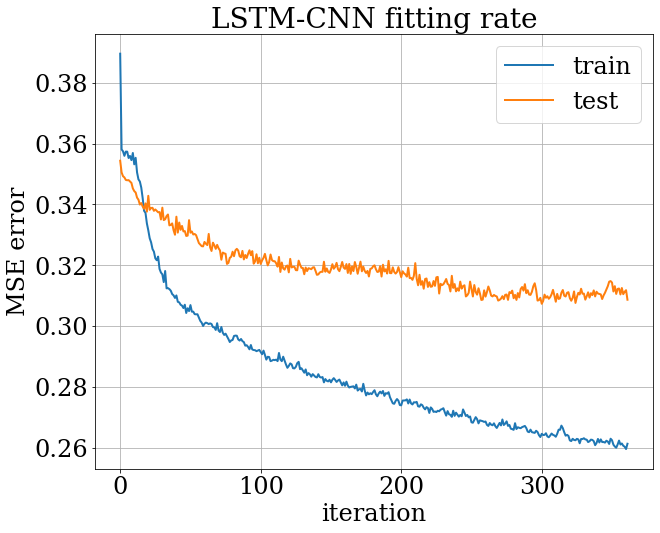

In [172]:
#draw only with errors from training
plt.figure(figsize =(10,8))
plt.plot(errors['train'], label = 'train')
plt.plot(errors['test'], label = 'test')
plt.xlabel('iteration')
plt.ylabel('MSE error')
plt.title('LSTM-CNN fitting rate')
plt.legend()
plt.grid()
plt.show()

Depict predictions and originals

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


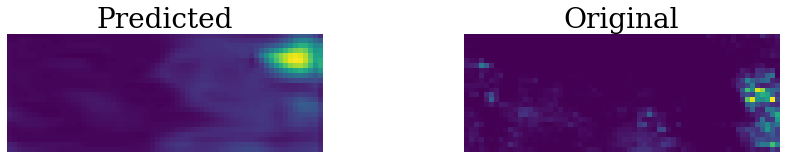

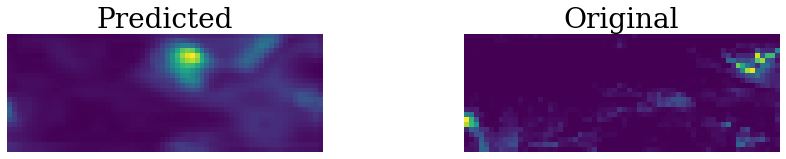

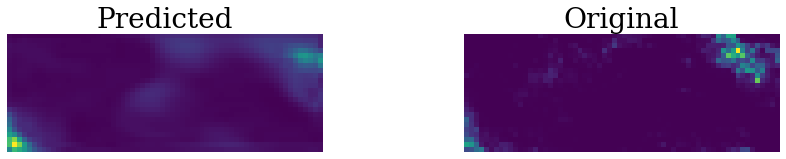

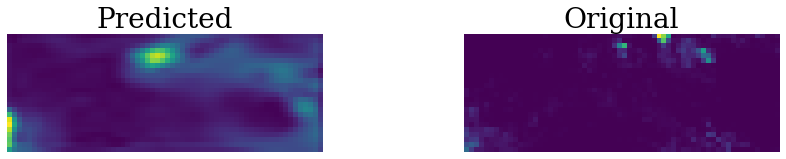

In [24]:
N = 4
for i in range(N):
    index = np.random.randint(150,250)
    y = best_model(torch.Tensor(X_test[index:index+1,:,:,:]).to(DEVICE))
    y = y.cpu().detach().numpy().squeeze()

    plt.figure(figsize = (15,10))
    plt.subplot(N,2,2*i+1)
    plt.imshow(y[2])
    plt.title('Predicted')
    plt.axis('off')
    plt.subplot(N,2,2*i+2)
    plt.imshow(y_test[index][2])
    plt.title('Original')
    plt.axis('off')
    plt.show()